In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

from OOPAO.calibration.compute_KL_modal_basis import compute_M2C, compute_KL_basis

from trwfs.tools.PWFS_CMOS_NOISE_PROOF_may2022_tools import *
from tqdm import trange
from OOPAO.TR_Pyramid import TR_Pyramid
from pypet import Environment, cartesian_product
from trwfs.parameter_files.parameterFile_TR_PWFS_closed_loop import initializeParameterFile
from OOPAO.tools.displayTools           import displayMap

param = initializeParameterFile()

# %% -----------------------     TELESCOPE   ----------------------------------

# create the Telescope object
tel = Telescope(resolution=param['resolution'], \
                diameter=param['diameter'], \
                samplingTime=param['samplingTime'], \
                centralObstruction=param['centralObstruction'])

# %% -----------------------     NGS   ----------------------------------
# create the Source object
ngs = Source(optBand=param['opticalBand'], \
             magnitude=1.0)

# combine the NGS to the telescope using '*' operator:
ngs * tel

tel.computePSF(zeroPaddingFactor=6)

# %% -----------------------     ATMOSPHERE   ----------------------------------

# create the Atmosphere object
atm = Atmosphere(telescope=tel, \
                 r0=param['r0'], \
                 L0=param['L0'], \
                 windSpeed=param['windSpeed'], \
                 fractionalR0=param['fractionnalR0'], \
                 windDirection=param['windDirection'], \
                 altitude=param['altitude'])

# initialize atmosphere
atm.initializeAtmosphere(tel)
#
# self.atm.update()
#
# self.tel + self.atm
# self.tel.computePSF(8)

# %% -----------------------     DEFORMABLE MIRROR   ----------------------------------
# mis-registrations object
misReg = MisRegistration(param)
# if no coordonates specified, create a cartesian dm

dm = DeformableMirror(telescope=tel, \
                      nSubap=param['nSubaperture'], \
                      mechCoupling=param['mechanicalCoupling'], \
                      misReg=misReg)


M2C_KL = compute_M2C(telescope            = tel, \
                     atmosphere         = atm, \
                     deformableMirror   = dm, \
                     param              = None, \
                     nameFolder         = None, \
                     nameFile           = None, \
                     remove_piston      = True, \
                     HHtName            = None, \
                     baseName           = None , \
                     mem_available      = 1e9, \
                     minimF             = False, \
                     nmo                = param["nModes"], \
                     ortho_spm          = True, \
                     SZ                 = np.int64(2*tel.OPD.shape[0]), \
                     nZer               = 3, \
                     NDIVL              = 1, \
                     recompute_cov=True, \
                     save_output= False)
                     #lim_inversion=0)


wfs = TR_Pyramid(nSubap=param['nSubaperture'], \
                 telescope=tel, \
                 modulation=param['modulation'], \
                 lightRatio=param['lightThreshold'], \
                 n_pix_separation=8,
                 calibModulation=param['calibrationModulation'], \
                 psfCentering=param['psfCentering'], \
                 n_pix_edge=4,
                 extraModulationFactor=param['extraModulationFactor'], \
                 postProcessing=param['postProcessing'],
                 nTheta_user_defined = param['nTheta_user_defined'])



# wfs_unmod = TR_Pyramid(nSubap=param['nSubaperture'], \
#                  telescope=tel, \
#                  modulation=0, \
#                  lightRatio=param['lightThreshold'], \
#                  n_pix_separation=4,
#                  calibModulation=param['calibrationModulation'], \
#                  psfCentering=param['psfCentering'], \
#                  n_pix_edge=2,
#                  extraModulationFactor=param['extraModulationFactor'], \
#                  postProcessing=param['postProcessing'],
#                  nTheta_user_defined = param['nTheta_user_defined'])



     °          *      *      
 ▄██▄   ▄██▄  ▄███▄   ▄██▄ * ▄██▄ 
██* ██ ██  ██ ██  ██ ██  ██ ██  ██
██  ██ ██° ██ ██  ██ ██* ██ ██  ██
██  ██ ██  ██ ████▀  ██▄▄██ ██  ██
██* ██ ██  ██ ██     ██▀▀██ ██  ██
██  ██ ██  ██ ██ *   ██  ██ ██* ██
 ▀██▀   ▀██▀  ██   ° ██  ██  ▀██▀ 
      *         *             


Reading/Writting calibration data from data_calibration/
Writting output data in data_cl/
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             8                [m]        
    Resolution           120             [pixels]     
    Pixel Size           0.07              [m]        
     Surface             50.0              [m2]       
Central Obstruction        0          [% of diameter]  
Pixels in the pupil      11304            [pixels]     
      Source             None                         
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
No light propagated through the telescope
%%%%%%%%%%%%%%%%%%%%%%%%

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


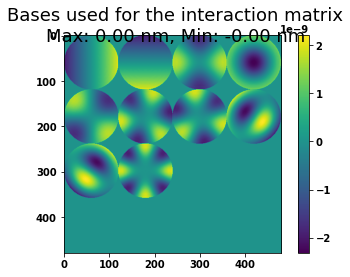

In [2]:
dm.coefs = M2C_KL[:, 0:10] * 1e-9
tel * dm * wfs
displayMap(tel.OPD)

Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


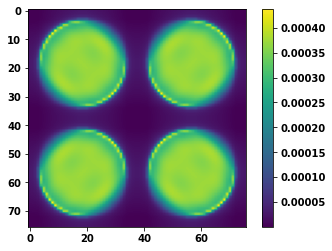

In [3]:
dm.coefs = 0
wfs.modulation = param["modulation"]
tel * dm * wfs
im = plt.imshow(wfs.referenceSignal_2D)
im1_cbar = plt.colorbar(im)

Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


Text(0.5, 0, 'KL mode')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


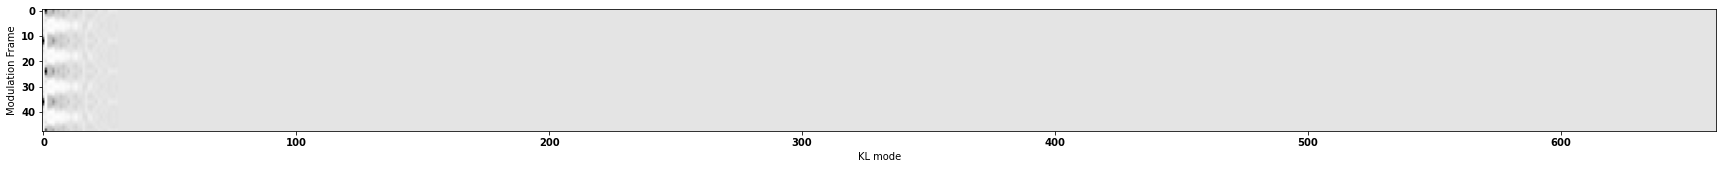

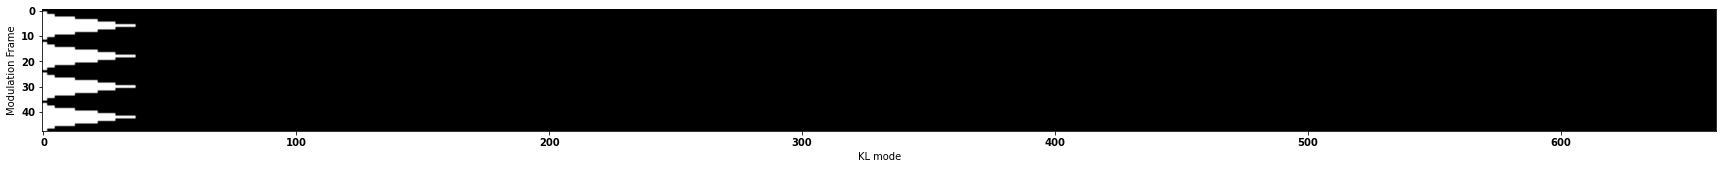

In [4]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = M2C_KL.shape[1]
stroke = 1*1e-9

all_validSignal = (np.ones(wfs.validSignal.shape) == 1)

valid_pixels = wfs.validSignal

i_cube = np.zeros((wfs.nTheta, np.sum(valid_pixels), nModes))
# ngs.nPhoton = 10000000000
wfs.modulation = param['modulation']
dm.coefs = 0
ngs* tel * dm * wfs
ref_cube = wfs.cam.cube[:, valid_pixels]
#ref_cube_c = np.zeros((ref_cube.shape[0], nModes))
#push_cube_c = np.zeros((ref_cube.shape[0], nModes))
#pull_cube_c = np.zeros((ref_cube.shape[0], nModes))
#to_cov = np.zeros(())
# bases = generateBases(nModes, tel.resolution, baseType="KL", display=False, scale=False)
for i in range(nModes):

    #t = np.sqrt(np.mean((ref_cube/np.sum(ref_cube))**2, axis=1))
    #ref_cube_c[:,i] = np.sqrt(np.mean((ref_cube/np.sum(ref_cube))**2, axis=1))/stroke
    dm.coefs = M2C_KL[:, i] * stroke
    tel * dm * wfs
    push = wfs.cam.cube[:, valid_pixels]
    push_signal = push/np.sum(push) - \
                      ref_cube/np.sum(ref_cube)

    #push_cube_c[:,i] = np.sqrt(np.mean((push/np.sum(push))**2, axis=1))/stroke
    if i == 0:
        push_cube_c = np.mean(push_signal, axis=1)/stroke

    dm.coefs = -M2C_KL[:, i] * stroke
    tel * dm * wfs
    pull = wfs.cam.cube[:, valid_pixels]
    pull_signal = pull/np.sum(pull) - \
                      ref_cube/np.sum(ref_cube)
    if i == 0:
        pull_cube_c = np.mean(pull_signal, axis=1)/stroke

    i_cube[:,:,i] = (0.5 * (push_signal - pull_signal) / stroke)



weighting_cube = np.ones((wfs.nTheta, nModes))
for i in range(30):
    #weighting_cube[:,i] = (np.std(i_cube[:, :, i], axis=1))
    avg_val = np.mean(i_cube[:, :, i])
    #avg_val = 0
    weighting_cube[:,i] = np.sqrt((np.mean((i_cube[:, :, i]-avg_val)**2, axis=1)))
    #weighting_cube[:,i] = -(weighting_cube[:,i] - np.mean(weighting_cube[:,i]))
    weighting_cube[:,i] = (weighting_cube[:,i]  / np.sum(np.abs(weighting_cube[:,i])))*48

    #weighting_cube[:,i] = np.arctan(weighting_cube[:,i])

plt.figure(figsize=(30,20))
im1 = plt.imshow(weighting_cube, cmap=cm.Greys)
#im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")



framesRemPerFace = [11, 11, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                                      3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]
binary_weight_cube = np.ones((wfs.nTheta, nModes))
for f in range(len(framesRemPerFace)):
    idx = calcEquidistantFrameIndices(framesRemPerFace[f], wfs.nTheta)
    binary_weight_cube[idx, f] = 0

plt.figure(figsize=(30,20))
im2 = plt.imshow(binary_weight_cube, cmap=cm.Greys)
#im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")

In [5]:
# What is the sum for each frame of weights
print(np.sum(weighting_cube, axis=0))
print(np.sum(weighting_cube, axis=1))

[48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48.
 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48. 48

In [6]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = M2C_KL.shape[1]
stroke = 1*1e-9


def getInterationMatrixModulated(weights, mod=5):
    imat = np.zeros((np.sum(valid_pixels), nModes))
    wfs.modulation = mod
    dm.coefs = 0
    tel * dm * wfs
    ref_cube = wfs.cam.cube[:, valid_pixels]

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.cube[:, valid_pixels]
        push_signal = np.sum(push*weights[:, np.newaxis, m], axis=0)/np.sum(push*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])


        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.cube[:, valid_pixels]
        pull_signal = np.sum(pull*weights[:, np.newaxis, m], axis=0)/np.sum(pull*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])

        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.std(imat[:,m] )
    return imat

def getInterationMatrixUnmodulated():
    imat = np.zeros((np.sum(valid_pixels), nModes))
    wfs.modulation = 0
    dm.coefs = 0
    tel * dm * wfs
    ref_frame = wfs.cam.frame[valid_pixels]

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.frame[valid_pixels]
        push_signal = push/np.sum(push) - \
                      ref_frame/np.sum(ref_frame)



        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.frame[valid_pixels]
        pull_signal = pull/np.sum(pull) - \
                      ref_frame/np.sum(ref_frame)


        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.std(imat[:,m] )

    return imat

I_mat_modulated = getInterationMatrixModulated(np.ones((wfs.nTheta, nModes)), mod=param['modulation'])
#I_mat_unmodulated = getInterationMatrixUnmodulated()
I_mat_weighted = getInterationMatrixModulated(weighting_cube, mod=param['modulation'])
#I_mat_binary = getInterationMatrixModulated(binary_weight_cube, mod=param['modulation'])


I_mat_modulated_inv = inv(I_mat_modulated.T @ I_mat_modulated) @ I_mat_modulated.T
#I_mat_unmodulated_inv = inv(I_mat_unmodulated.T @ I_mat_unmodulated) @ I_mat_unmodulated.T
I_mat_weighted_inv = inv(I_mat_weighted.T @ I_mat_weighted) @ I_mat_weighted.T
#I_mat_binary_inv = inv(I_mat_binary.T @ I_mat_binary) @ I_mat_binary.T


Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


In [7]:
print(np.sum(I_mat_modulated_inv, axis=0))
print(np.sum(I_mat_modulated_inv, axis=1))

print(I_mat_modulated_inv.shape)

[-1.16854218e-06  1.98125181e-06  2.64953683e-07 ...  4.08331080e-07
 -1.08019132e-06 -4.11093689e-06]
[ 6.25445740e-16  7.00394603e-17  4.67291136e-17  5.70290343e-17
  1.12310851e-16  5.48267486e-17  6.37646403e-17  5.32207741e-17
 -3.37525689e-17  2.20838430e-17 -2.90185017e-17 -1.81265051e-17
 -5.29226185e-18 -2.58499632e-17 -5.74288338e-18 -2.79249822e-17
 -2.43098456e-19 -1.09927936e-17 -1.29858621e-17  1.13218659e-17
  1.67001016e-17  9.83807592e-18 -1.21888041e-17 -7.65167213e-18
 -2.08708918e-17  1.12308098e-17 -5.51926668e-18 -9.79170087e-19
  1.12464270e-17  3.63038321e-18 -7.64108422e-18 -4.48927462e-18
  2.31134115e-18  2.19889753e-18 -5.79031723e-18  3.51179860e-18
 -9.57655450e-18  2.33611687e-18 -1.88126018e-18  7.21079148e-18
  2.97202685e-18 -9.71377384e-18  7.43202590e-18 -2.31324698e-18
 -6.11727195e-18  3.95363216e-18  2.68932961e-18  9.53653219e-18
 -7.35436356e-19 -1.09944877e-18  5.58406470e-19  1.28854887e-18
 -3.38474366e-18 -5.76914140e-18  7.04392599e-18  1.

In [8]:
print(np.sum(I_mat_weighted_inv, axis=0))
print(np.sum(I_mat_weighted_inv, axis=1))

[-1.23525125e-06  1.92830410e-06  2.21341257e-07 ...  6.04918632e-07
 -8.68183972e-07 -3.85357146e-06]
[-1.85974554e-17 -3.39355280e-17  1.72388145e-17 -2.56142763e-17
 -5.34530729e-18  2.99748019e-17  3.78318796e-17 -9.96110746e-18
  1.33492392e-17  1.32408190e-17 -2.48244181e-17 -2.05049736e-17
  1.71439469e-17  3.09330609e-17 -6.85588468e-18 -3.73033310e-18
  1.30358371e-17 -4.68070407e-18  1.57006027e-17 -6.96854006e-18
 -3.00527290e-17  1.14241451e-17  3.42031904e-18  8.59659032e-18
 -1.54469163e-17 -2.33230522e-17  3.47452915e-18 -8.48727013e-19
 -1.53482370e-18  2.11758237e-20 -2.32595247e-18 -6.03087458e-18
  1.27054942e-21  4.85349879e-18 -1.12655382e-19  7.00750357e-18
 -4.54771989e-18  1.25191470e-18 -1.19346942e-18  1.59339603e-17
  1.75219353e-18 -5.84876250e-18  8.29176434e-18 -3.47961135e-18
 -4.65952824e-18  6.11113096e-18 -3.15096256e-19  8.54296255e-18
 -1.20935129e-18  7.96380377e-18  1.05730888e-18 -2.17052193e-19
 -6.55645853e-18 -7.70715279e-18  5.14699570e-18  4.

# Finally, with the interaction matrix, we should be able the calculate the sensitivity of the system.
This is the part I struggle with, I am usure why I don't get values between 0 and 2 like in the litterature. Here I'm following formula 3.11 from Chambouleyron's thesis.

$$ s_b (\phi_i) = \| \delta I(\phi_i) \|_2   $$

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


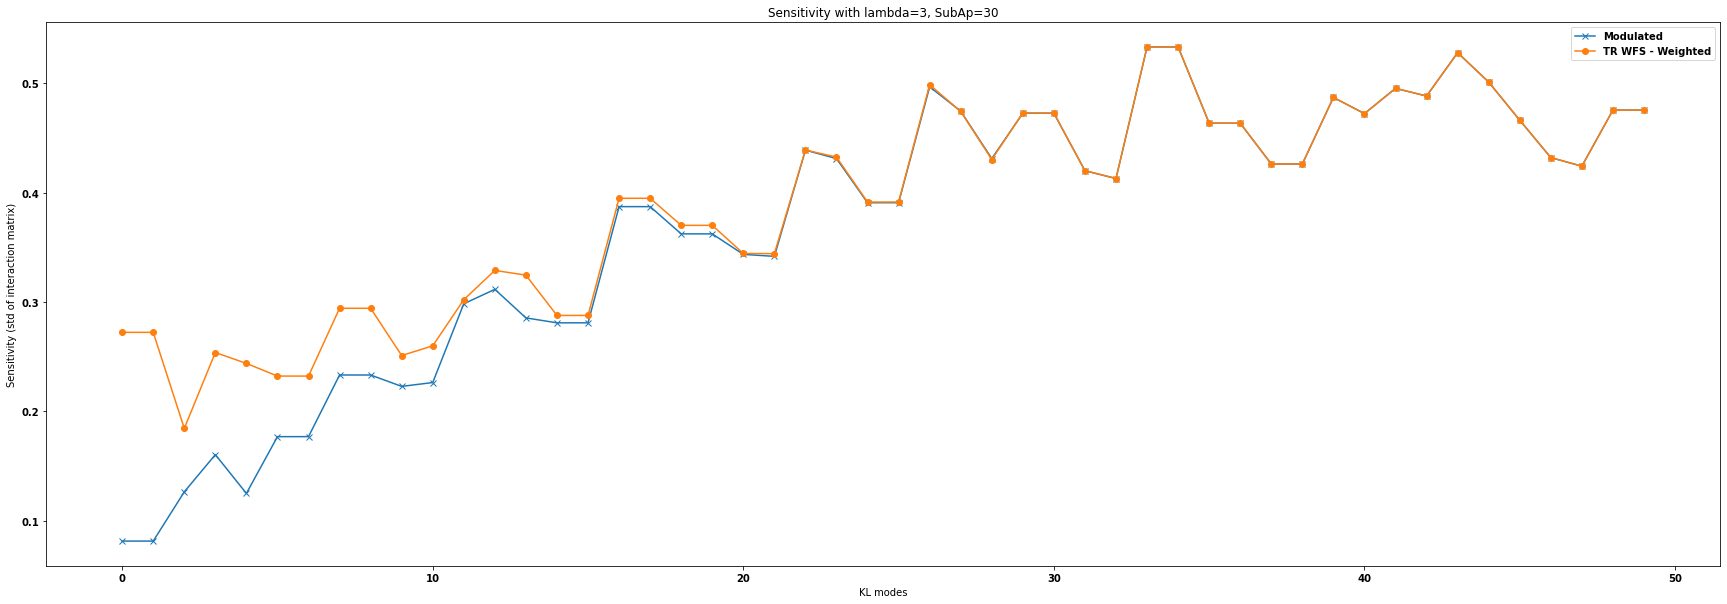

In [9]:
radian_in_1m = (2*np.pi)/ ngs.wavelength
plt.figure(figsize=(30,10))
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_modulated)**2, axis=0))[0:50] / radian_in_1m, marker="x",label="Modulated")
#plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_unmodulated - np.mean(I_mat_modulated, axis=0) )**2, axis=0)) / radian_in_1m, marker="o",label="Unmodulated")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_weighted )**2, axis=0))[0:50] / radian_in_1m, marker="o", label="TR WFS - Weighted")
#plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_binary )**2, axis=0)) / radian_in_1m, marker="o", label="TR WFS - Binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.title(f"Sensitivity with lambda={param['modulation']}, SubAp={wfs.nSubap}")
plt.legend()

Text(0.5, 0.98, 'Comparing optical gain across modes between\ntime-resolved and normal pyramid wavefront sensor')

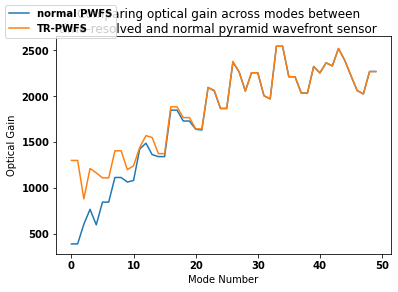

In [10]:
fig, (ax1) = plt.subplots(1)
ax1.plot(np.std(I_mat_modulated,axis=0)[0:50], label="normal PWFS")
ax1.plot(np.std(I_mat_weighted,axis=0)[0:50], label="TR-PWFS")
plt.xlabel('Mode Number')
plt.ylabel('WFS slopes STD')
plt.ylabel('Optical Gain')
fig.legend(loc="upper left")
fig.suptitle("Comparing optical gain across modes between\ntime-resolved and normal pyramid wavefront sensor")

Text(0.5, 0.98, 'Comparing noise propagation')

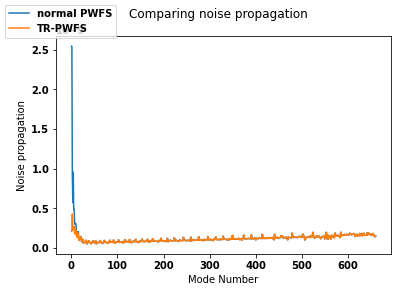

In [11]:
fig, (ax2) = plt.subplots(1)
ax2.plot(np.diag(I_mat_modulated_inv@I_mat_modulated_inv.T), label="normal PWFS")
ax2.plot(np.diag(I_mat_weighted_inv@I_mat_weighted_inv.T), label="TR-PWFS")
plt.xlabel('Mode Number')
plt.ylabel('Noise propagation')
fig.legend(loc="upper left")
fig.suptitle("Comparing noise propagation")

In [12]:
param['fractionnalR0'        ] = [1.0]                                            # Cn2 profile
param['windSpeed'            ] = [20]                                          # wind speed of the different layers in [m.s-1]
param['windDirection'        ] = [90]                                            # wind direction of the different layers in [degrees]
param['altitude'             ] = [0]

# recreate the Atmosphere object, to reset the atmosphere to the same starting point
atm = Atmosphere(telescope=tel, \
                 r0=param['r0'], \
                 L0=param['L0'], \
                 windSpeed=param['windSpeed'], \
                 fractionalR0=param['fractionnalR0'], \
                 windDirection=param['windDirection'], \
                 altitude=param['altitude'])

# initialize atmosphere
atm.initializeAtmosphere(tel)

Creation of layer1/1 ...
-> Computing the initial phase screen...
initial phase screen : 0.013463020324707031 s
ZZt.. : 0.5599842071533203 s
ZXt.. : 0.23237395286560059 s
XXt.. : 0.12620949745178223 s
Done!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%% ATMOSPHERE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
   Layer     Direction     Speed      Altitude      Cn2     
               [deg]       [m/s]        [m]       [m-2/3]   
----------------------------------------------------------------------
     1           90          20          0          1.0     
------------------------------------------------------------------
    r0 @500 nm         0.6 [m]      
        L0              30 [m]      
  Seeing @500nm        0.17 ["]     
    Frequency        1000.0 [Hz]    
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


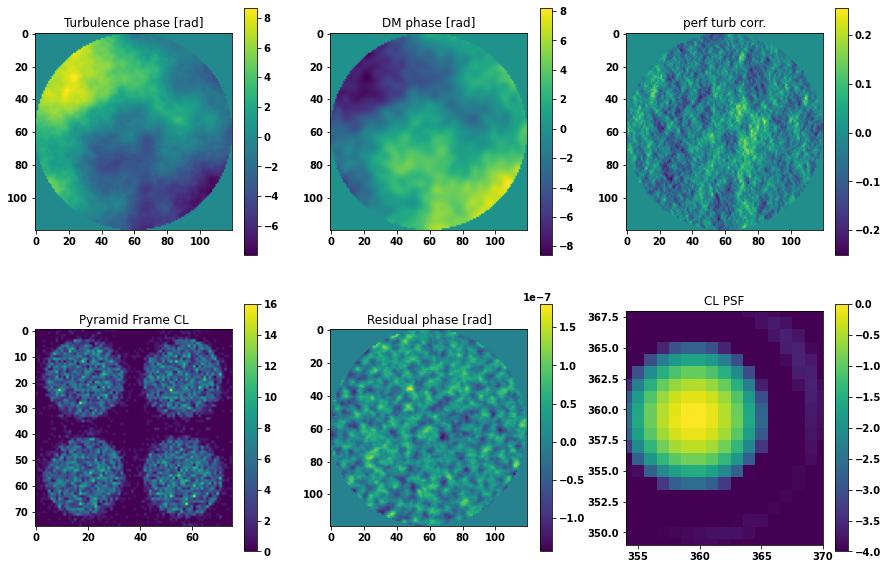

Loop499/500 Turbulence: 315.16586381829626 -- Residual:37.943890885762244



In [13]:

# These are the calibration data used to close the loop
calib_CL    = I_mat_weighted_inv
M2C_CL      = M2C_KL

wfs.cam.photonNoise = True
param['nLoop'] =500
plt.close('all')

# Define a source with the magnitude we want
ngs = Source(optBand=param['opticalBand'], \
             magnitude=11.0)

# combine the NGS to the telescope using '*' operator:
ngs * tel

tel.computePSF(zeroPaddingFactor=6)

# combine telescope with atmosphere
tel+atm

# initialize DM commands
dm.coefs=0
ngs*tel*dm*wfs

plt.ion()
# setup the display
fig         = plt.figure(79, figsize=(15,10))
ax1         = plt.subplot(2,3,1)
im_atm      = ax1.imshow(tel.src.phase)
plt.colorbar(im_atm)
plt.title('Turbulence phase [rad]')

ax2         = plt.subplot(2,3,2)
im_dm       = ax2.imshow(dm.OPD*tel.pupil)
plt.colorbar(im_dm)
plt.title('DM phase [rad]')
tel.computePSF(zeroPaddingFactor=6)

ax4         = plt.subplot(2,3,3)
im_perf_turb = ax4.imshow(tel.src.phase)
plt.colorbar(im_perf_turb)
plt.title('perf turb corr.')
# im_PSF_OL   = ax4.imshow(tel.PSF)
# plt.colorbar(im_PSF_OL)
# plt.title('OL PSF')


ax3         = plt.subplot(2,3,5)
im_residual = ax3.imshow(tel.src.phase)
plt.colorbar(im_residual)
plt.title('Residual phase [rad]')

ax5         = plt.subplot(2,3,4)
im_wfs_CL   = ax5.imshow(wfs.cam.frame)
plt.colorbar(im_wfs_CL)
plt.title('Pyramid Frame CL')

ax6         = plt.subplot(2,3,6)
im_PSF      = ax6.imshow(tel.PSF)
plt.colorbar(im_PSF)
plt.title('CL PSF')

plt.show()

# allocate memory to save data
SR                      = np.zeros(param['nLoop'])
total                   = np.zeros(param['nLoop'])
residual                = np.zeros(param['nLoop'])
prev_turb               = np.zeros(tel.src.phase.shape)
#wfsSignal               = np.arange(0,wfs.nSignal)*0
wfsSignal = np.zeros((wfs.cam.cube[:, valid_pixels]).shape)
a_est = np.zeros((M2C_CL.shape[1]))
# loop parameters
gainCL                  = 0.4
wfs.cam.photonNoise     = True
update_figures          = True

for i in range(param['nLoop']):
    a=time.time()
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()
     # save phase variance
    total[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
     # save turbulent phase
    turbPhase = tel.src.phase
    if update_figures == True:
           # compute the OL PSF and update the display
       tel.computePSF(zeroPaddingFactor=6)
       #im_PSF_OL.set_data(np.log(tel.PSF/tel.PSF.max()))
       #im_PSF_OL.set_clim(vmin=-3,vmax=0)

     # propagate to the WFS with the CL commands applied
    tel*dm*wfs

     # save the DM OPD shape
    dmOPD=tel.pupil*dm.OPD*2*np.pi/ngs.wavelength
    
    
    # for j_mode in range(len(a_est)):
    #     t_signal = wfs.cam.cube[:, wfs.validSignal]
    #     t_t_signal = np.sum(t_signal*weighting_cube[:, np.newaxis, j_mode], axis=0)/np.sum(t_signal*weighting_cube[:, np.newaxis, j_mode]) - \
    #                   np.sum(ref_cube*weighting_cube[:, np.newaxis, j_mode], axis=0)/np.sum(ref_cube*weighting_cube[:, np.newaxis, j_mode])
    #     #weighted_signal = wfsSignal * self.weightsPerFramePerMode[j_mode, :, np.newaxis]
    #     a_est[j_mode] = ( calib_CL @ t_t_signal)[j_mode]

    t_signal = wfsSignal
    t_t_signal = (t_signal.T @ weighting_cube[:,  :]) / np.sum(t_signal.T @ weighting_cube[:, :], axis=0) - \
                 (ref_cube.T @ weighting_cube[:, :]) / np.sum(ref_cube.T @ weighting_cube[:, :], axis=0)
    a_est = np.diag(calib_CL @ t_t_signal)

    a_est = np.nan_to_num(a_est, nan=0)

    correction = np.matmul(M2C_CL, a_est)
    
    dm.coefs=dm.coefs - gainCL*correction
     # store the slopes after computing the commands => 2 frames delay
    wfsSignal = wfs.cam.cube[:, valid_pixels]
    b= time.time()
    #print('Elapsed time: ' + str(b-a) +' s')
    # update displays if required
    if update_figures==True:

       # Turbulence
       im_atm.set_data(turbPhase)
       im_atm.set_clim(vmin=turbPhase.min(),vmax=turbPhase.max())

       # Turbulence perf corr
       perf_turb_corr = prev_turb-turbPhase
       im_perf_turb.set_data(perf_turb_corr)
       im_perf_turb.set_clim(vmin=perf_turb_corr.min(),vmax=perf_turb_corr.max())

       # WFS frame
       C=wfs.cam.frame
       im_wfs_CL.set_data(C)
       im_wfs_CL.set_clim(vmin=C.min(),vmax=C.max())
       # DM OPD
       im_dm.set_data(dmOPD)
       im_dm.set_clim(vmin=dmOPD.min(),vmax=dmOPD.max())

       # residual phase
       #D=tel.src.phase
       #D=D-np.mean(D[tel.pupil])
       D =tel.OPD
       im_residual.set_data(D)
       im_residual.set_clim(vmin=D.min(),vmax=D.max())

       tel.computePSF(zeroPaddingFactor=6)
       data = np.log(tel.PSF/tel.PSF.max())
       im_PSF.set_data(data)
       im_PSF.set_clim(vmin=-4,vmax=0)
       # Zoom automatically on the PSF
       bound = np.argwhere(data>=(-4))
       ax6.set_xlim(min(bound[:, 1]), max(bound[:, 1]))
       ax6.set_ylim(min(bound[:, 0]), max(bound[:, 0]))

       #plt.draw()
       #plt.show()
       clear_output(wait = True)
       display(fig)
       plt.pause(0.001)


    SR[i]=np.exp(-np.var(tel.src.phase[np.where(tel.pupil==1)]))
    residual[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    OPD=tel.OPD[np.where(tel.pupil>0)]
    prev_turb = turbPhase

# Print the final stats
print('Loop'+str(i)+'/'+str(param['nLoop'])+' Turbulence: '+str(np.mean(total[100:i]))+' -- Residual:' +str(np.mean(residual[100:i]))+ '\n')


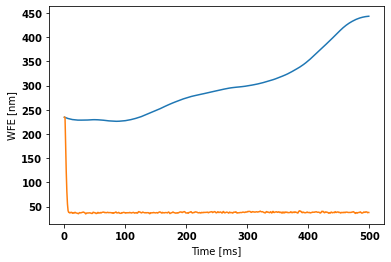

In [14]:
plt.figure()
plt.plot(total)
plt.plot(residual)
plt.xlabel('Time [ms]')
plt.ylabel('WFE [nm]')

plt.pause(10)


In [15]:
# recreate the Atmosphere object, to reset the atmosphere to the same starting point
atm = Atmosphere(telescope=tel, \
                 r0=param['r0'], \
                 L0=param['L0'], \
                 windSpeed=param['windSpeed'], \
                 fractionalR0=param['fractionnalR0'], \
                 windDirection=param['windDirection'], \
                 altitude=param['altitude'])

# initialize atmosphere
atm.initializeAtmosphere(tel)

Creation of layer1/1 ...
-> Computing the initial phase screen...
initial phase screen : 0.011223793029785156 s
ZZt.. : 0.5303537845611572 s
ZXt.. : 0.23097991943359375 s
XXt.. : 0.11814761161804199 s
Done!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%% ATMOSPHERE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
   Layer     Direction     Speed      Altitude      Cn2     
               [deg]       [m/s]        [m]       [m-2/3]   
----------------------------------------------------------------------
     1           90          20          0          1.0     
------------------------------------------------------------------
    r0 @500 nm         0.6 [m]      
        L0              30 [m]      
  Seeing @500nm        0.17 ["]     
    Frequency        1000.0 [Hz]    
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


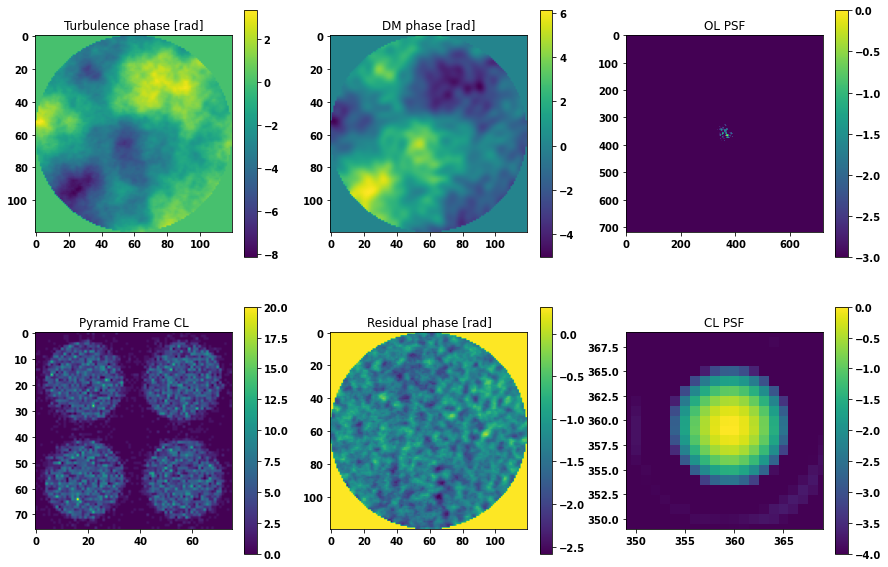

In [ ]:

# These are the calibration data used to close the loop
calib_CL    = I_mat_modulated_inv
M2C_CL      = M2C_KL

wfs.cam.photonNoise = True
param['nLoop'] =500
plt.close('all')

# combine telescope with atmosphere
tel+atm

# initialize DM commands
dm.coefs=0
ngs*tel*dm*wfs

plt.ion()
# setup the display
fig         = plt.figure(79, figsize=(15,10))
ax1         = plt.subplot(2,3,1)
im_atm      = ax1.imshow(tel.src.phase)
plt.colorbar(im_atm)
plt.title('Turbulence phase [rad]')

ax2         = plt.subplot(2,3,2)
im_dm       = ax2.imshow(dm.OPD*tel.pupil)
plt.colorbar(im_dm)
plt.title('DM phase [rad]')
tel.computePSF(zeroPaddingFactor=6)

ax4         = plt.subplot(2,3,3)
im_PSF_OL   = ax4.imshow(tel.PSF)
plt.colorbar(im_PSF_OL)
plt.title('OL PSF')


ax3         = plt.subplot(2,3,5)
im_residual = ax3.imshow(tel.src.phase)
plt.colorbar(im_residual)
plt.title('Residual phase [rad]')

ax5         = plt.subplot(2,3,4)
im_wfs_CL   = ax5.imshow(wfs.cam.frame)
plt.colorbar(im_wfs_CL)
plt.title('Pyramid Frame CL')

ax6         = plt.subplot(2,3,6)
im_PSF      = ax6.imshow(tel.PSF)
plt.colorbar(im_PSF)
plt.title('CL PSF')

plt.show()

# allocate memory to save data
SR                      = np.zeros(param['nLoop'])
total                   = np.zeros(param['nLoop'])
residual                = np.zeros(param['nLoop'])
#wfsSignal = np.zeros((wfs.cam.frame[valid_pixels]).shape)

wfsSignal               = np.arange(0,wfs.nSignal)*0

# loop parameters
gainCL                  = 0.4
wfs.cam.photonNoise     = True
update_figures          = True

for i in range(param['nLoop']):
    a=time.time()
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()
     # save phase variance
    total[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
     # save turbulent phase
    turbPhase = tel.src.phase
    if update_figures == True:
           # compute the OL PSF and update the display
       tel.computePSF(zeroPaddingFactor=6)
       im_PSF_OL.set_data(np.log(tel.PSF/tel.PSF.max()))
       im_PSF_OL.set_clim(vmin=-3,vmax=0)

     # propagate to the WFS with the CL commands applied
    tel*dm*wfs

     # save the DM OPD shape
    dmOPD=tel.pupil*dm.OPD*2*np.pi/ngs.wavelength

    dm.coefs=dm.coefs-gainCL*M2C_CL@calib_CL@wfsSignal
     # store the slopes after computing the commands => 2 frames delay
    wfsSignal=wfs.pyramidSignal
    b= time.time()
    #print('Elapsed time: ' + str(b-a) +' s')
    # update displays if required
    if update_figures==True:

       # Turbulence
       im_atm.set_data(turbPhase)
       im_atm.set_clim(vmin=turbPhase.min(),vmax=turbPhase.max())
       # WFS frame
       C=wfs.cam.frame
       im_wfs_CL.set_data(C)
       im_wfs_CL.set_clim(vmin=C.min(),vmax=C.max())
       # DM OPD
       im_dm.set_data(dmOPD)
       im_dm.set_clim(vmin=dmOPD.min(),vmax=dmOPD.max())

       # residual phase
       D=tel.src.phase
       D=D-np.mean(D[tel.pupil])
       im_residual.set_data(D)
       im_residual.set_clim(vmin=D.min(),vmax=D.max())

       tel.computePSF(zeroPaddingFactor=6)
       data = np.log(tel.PSF/tel.PSF.max())
       im_PSF.set_data(data)
       im_PSF.set_clim(vmin=-4,vmax=0)
       # Zoom automatically on the PSF
       bound = np.argwhere(data>=(-4))
       ax6.set_xlim(min(bound[:, 1]), max(bound[:, 1]))
       ax6.set_ylim(min(bound[:, 0]), max(bound[:, 0]))

       #plt.draw()
       #plt.show()
       clear_output(wait = True)
       display(fig)
       plt.pause(0.001)


    SR[i]=np.exp(-np.var(tel.src.phase[np.where(tel.pupil==1)]))
    residual[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    OPD=tel.OPD[np.where(tel.pupil>0)]

#Print the final stats
print('Loop'+str(i)+'/'+str(param['nLoop'])+' Turbulence: '+str(np.mean(total[100:i]))+' -- Residual:' +str(np.mean(residual[100:i]))+ '\n')


In [ ]:
plt.figure()
plt.plot(total)
plt.plot(residual)
plt.xlabel('Time [ms]')
plt.ylabel('WFE [nm]')

plt.pause(10)
